In [2]:
DATASET_PATH = '../data/raw/statue_faces/'
MODEL_PATH   = '../models/shape_predictor_68_face_landmarks.dat'

### Import dependencies

In [3]:
import dlib
import cv2
import matplotlib.pyplot as plt
import PIL
import json
import os
from PIL import Image
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(MODEL_PATH)

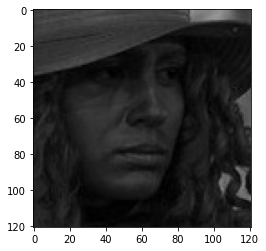

In [4]:
img = cv2.imread('../data/raw/statue_faces/0258.jpg')
plt.imshow(img)

### Rename files in dataset

In [5]:
files = os.listdir(DATASET_PATH)
for k, filename in enumerate(files):
    os.rename(f'{DATASET_PATH}/{filename}', f'{DATASET_PATH}/{(k+1):04d}.jpg')

### Reshape files in dataset to 128 x 128

In [6]:
SHAPE_128x128 = (128, 128)
DATASET_128x128_PATH = '../data/processed/statue_faces_128x128'
files = os.listdir(DATASET_PATH)
for k, filename in enumerate(files):
    img = Image.open(f'{DATASET_PATH}/{filename}')
    resized = img.resize(SHAPE_128x128)
    resized.save(f'{DATASET_128x128_PATH}/{filename}')

### Generate face landmarks for faces in dataset

Will generate a file with shape 
`````json
{
  "0001.jpg": {
    "00": {
      "x": 22,
      "y": 48
    },
    "01": {
      "x": 22,
      "y": 60
    },
    ...
    ,
    "66": {
      "x": 68,
      "y": 89
    },
    "67": {
      "x": 65,
      "y": 87
    },
    "height": 87,
    "left": 26,
    "top": 26,
    "width": 87
  },
  ...
}
`````


In [7]:
files = os.listdir(DATASET_128x128_PATH)
LANDMARKS_JSON_FILEPATH = '../data/processed/statue_faces_128x128_landmarks.json'
landmarks = {}

for file_path in files:
    path = f'{DATASET_128x128_PATH}/{file_path}'
    img = cv2.imread(path)
    faces = detector(img)
    if len(faces) == 1:
        face = faces[0]
        prediction = predictor(img, face)
        face_landmarks = {
            f'{k:02d}': {"x": p.x, "y": p.y}
            for k, p in enumerate(prediction.parts())
        }
        face_landmarks.update({
            "top": face.top(),
            "left": face.left(),
            "width": face.width(),
            "height": face.height()
        })
        landmarks.update({file_path: face_landmarks})

with open(LANDMARKS_JSON_FILEPATH, 'w') as landmarks_output:
    landmarks_output.write(
        json.dumps(landmarks, indent=2, sort_keys=True)
    )

In [8]:
with open(LANDMARKS_JSON_FILEPATH, 'r') as landmarks_fp:
    landmarks = json.load(landmarks_fp)

LANDMARKS_XML_FILEPATH = '../data/processed/statue_faces_predictor_train.xml'
xml_images = ''
for file in landmarks.keys():
    xml_images += f"    <image file='{file}'>\n"
    data = landmarks[file]
    top, left, width, height = data['top'], data['left'], data['width'], data['height']
    xml_images += f"        <box top='{top}' left='{left}' width='{width}' height='{height}'>\n"

    for part in data.keys():
        if part not in ["top", "left", "width", "height"]:
            xml_images += f"            <part name='{part}' x='{data[part]['x']}' y='{data[part]['y']}'>\n"
    
    xml_images += f"        </box>\n"
    xml_images += f"    </image>\n"

xml_content = f'''<images>
{xml_images}<images>'''

with open(LANDMARKS_XML_FILEPATH, 'w') as train_xml:
    train_xml.write(xml_content)

### Reshape images

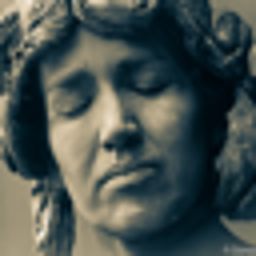

In [15]:
from PIL import Image
resized = Image.open('../data/raw/statue_faces/0111.jpg').resize((64, 64)).resize((256, 256))
display(resized)

### Generate masks

In [96]:
NUMBER_OF_MASKS = 32
PATH_TO_MASKS_128x128 = '../data/processed/masks_128x128/30x30'
MASKS = {}
import random
for i in range(NUMBER_OF_MASKS):    
    blank_image = Image.new('1', SHAPE_128x128, 0)
    random_x = random.randint(128/4, 3*128/4) - 20
    random_x_delta = 20
    random_y = random.randint(128/4, 3*128/4) - 20
    random_y_delta = 20
    pixels = blank_image.load()
    for x in range(128):
        for y in range(128):
            if x > random_x and x < random_x + random_x_delta:
                if y > random_y and y < random_y + random_y_delta:
                    random_R = 255
                    random_G = 255
                    random_B = 255
                    pixels[x, y] = 1
    blank_image.save(f'{PATH_TO_MASKS_128x128}/{i:02d}.jpg')
    MASKS.update({
        f'{i:02d}.jpg': {
            "x": random_x,
            "x_delta": random_x_delta,
            "y": random_y,
            "y_delta": random_y_delta
        }
    })


## Mask images

In [97]:
statue_faces_files = os.listdir(DATASET_128x128_PATH)
PATH_TO_MASKED_STATUES = '../data/processed/masked_statue_faces_128x128/30x30'
count = 0
import tqdm
for statue_face_file in tqdm.tqdm(statue_faces_files):
    count += 1
    for mask_id in MASKS.keys():
        statue_face_fp = f'{DATASET_128x128_PATH}/{statue_face_file}'
        statue_face_img = Image.open(statue_face_fp)
        statue_face_pixels = statue_face_img.load()
        random_x = MASKS[mask_id]['x']
        random_x_delta = MASKS[mask_id]['x_delta']
        random_y = MASKS[mask_id]['y']
        random_y_delta = MASKS[mask_id]['y_delta']
        for x in range(128):
            for y in range(128):
                if x > random_x and x < random_x + random_x_delta and y > random_y and y < random_y + random_y_delta:
                    random_R = 255
                    random_G = 255
                    random_B = 255
                    
                    statue_face_pixels[x, y] = (255, 255, 255)
        img_name = f'source_%s-mask_%s.jpg' % (statue_face_file.split('.')[0], mask_id.split('.')[0])
        statue_face_img.save(f'{PATH_TO_MASKED_STATUES}/{img_name}')

100%|██████████| 1409/1409 [01:06<00:00, 21.26it/s]


## TODO

1. generate face landmarks for masked images
2. generate XML landmarks for masked images
3. train dlib shape predictor with masked faces